In [95]:
import pystac_client
import xarray as xr
import rioxarray as rio
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np



In [177]:
# Set stac URL
STAC_url = "https://raw.githubusercontent.com/openearth/coclicodata/main/current/catalog.json"

# Open the catalog
catalog = pystac_client.Client.open(STAC_url)

# Get the AR6 collection
collection = catalog.get_child("slp")

# Get all items to iterate over
items = collection.get_all_items()

# Set area of interest polygon
polygon = Polygon(
    [
        [5.0713, 53.3602],
        [5.2567, 53.44],
        [5.5281, 53.4646],
        [5.6351, 53.4086],
        [5.1669, 53.3079],
        [5.0713, 53.3602]
    ]
)

ssps = ["high_end", "ssp126", "ssp245", "ssp585"]
msls = ["msl_h"]
years = ["2031","2041","2051", "2061", "2071", "2081", "2091", "2101","2111","2121","2131","2141","2151"]

filtered_items = []

slps = []

# Iterate over all ssps, ens and years
for ssp in ssps:
    for msl in msls:
        for year in years:
            # Get the item
            item = collection.get_item(f"{ssp}\{msl}\{year}.tif")
            
            # Get href
            href = item.assets["data"].href

            # Load tif into xarray
            ds = rio.open_rasterio(href, masked=True)

            # First clip to bounding box of polygon
            ds_clip = ds.rio.clip_box(*polygon.bounds, allow_one_dimensional_raster=True)

            ds_point = ds_clip.sel(x=polygon.centroid.x, y=polygon.centroid.y, method="nearest")

            # Check if nearest pixel to centroid has data, if not use max of ds_clip
            if not ds_point.notnull().values:

                # Find the maximum value in the dataset
                max_value = ds_clip.max()

                # Find the coordinates of the max value
                max_coords = ds_clip.where(ds == max_value, drop=True)

                # Retrieve the coordinates (x, y) for the maximum value
                max_x = max_coords.coords['x'].values
                max_y = max_coords.coords['y'].values

                # Select the dataset at the coordinates of the maximum value
                ds_point = ds_clip.sel(x=max_x, y=max_y)

            # Retrieve the point value
            value = ds_point.values.item()

            # Append the result as a dictionary
            slps.append({
                'ssp': ssp,
                'msl': msl,
                'year': year,
                'value': value
            })

    

c:\Users\soest\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\pystac_client\client.py:187: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())
c:\Users\soest\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\pystac_client\collection_client.py:186: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("FEATURES", "ITEM_SEARCH")
c:\Users\soest\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\pystac_client\collection_client.py:138: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")
c:\Users\soest\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\pystac_client\collection_client.py:186: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("FEATURES", "ITEM_SEARCH")
c:\Users\soest\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\pystac_client\collection_client.py:138: FallbackToPystac: Fa

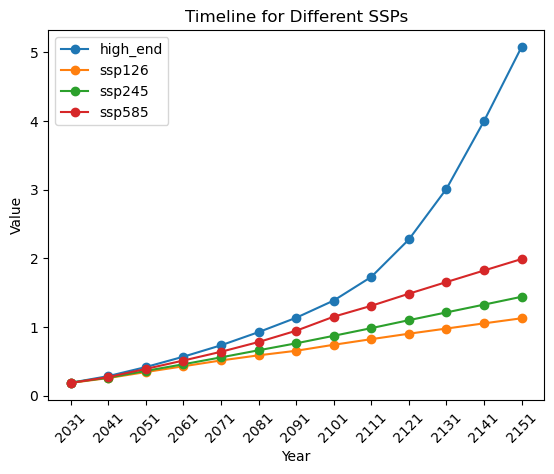

In [178]:
# Now, directly use the results to plot
for ssp in ssps:
    # Filter the data for the current ssp
    ssp_values = [slp['value'] for slp in slps if slp['ssp'] == ssp]
    ssp_years = [slp['year'] for slp in slps if slp['ssp'] == ssp]

    # Plot the data for this ssp
    plt.plot(ssp_years, ssp_values, label=ssp, marker='o')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Timeline for Different SSPs')
plt.legend()
plt.xticks(rotation=45)  # To make the years readable
plt.show()

In [18]:
# Assuming `collection` is your client object
query = {
    "ids": [f"{ssp}/{en}/{year}.tif" for ssp in ssps for en in ens for year in years]
}

items = collection.search(**query).get_all_items()

# Use the preloaded items
for item in items:
    print(item.id)

AttributeError: 'CollectionClient' object has no attribute 'search'